<a href="https://colab.research.google.com/github/janchorowski/dl_uwr/blob/summer2020/Assignment2/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

**Submission deadline: last lab session before or on Thursday, 26.03.2020**

**Points: 6 + 1 bonus points**

## Submission instructions
The class is held remotely. To sumbmit your solutions please save the notebook to your Google Drive, then:
1. Rename it it to: Assignment2_Surname_FirstName
2. Rerun the whole notebook `Runtime -> Restar and run all`
3. Make a pinned revision `File->Save and pin revision`
4. Share the notebook with your instructor using his `cs.uni.wroc.pl` email

We will use the commenting system and video conferences to check and discuss the solutions.

As always, please submit corrections using GitHub's Pull Requests.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D$ matrix.

Text(0, 0.5, 'X[1]')

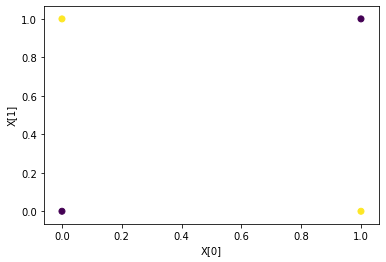

In [3]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1],
    ], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array(
    [[0],
     [1],
     [1],
     [0],
    ], dtype=np.float32)

plt.scatter(X[:,0], X[:,1], c=Y[:,0], )
plt.xlabel('X[0]')
plt.ylabel('X[1]')


# Problem 1 [2p]

Fill in the details of a forward pass, then manually set the weights and biases in the network to solve the 2D XOR task defined above.

In [4]:
def sigmoid(x):
    return 1 / (1 + np.e ** -x)

class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden, ), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # TODO Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 += np.random.randn(*self.W1.shape) / 2
        self.b1 += np.random.randn(*self.b1.shape) / 2
        self.W2 += np.random.randn(*self.W2.shape) / 2
        self.b2 += np.random.randn(*self.b2.shape) / 2

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)
        
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)
        
        if Y is not None:
            loss = -Y * np.log(O2) - (1-Y) * np.log(1-O2) # TODO_cross-entropy_loss
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2: fill in the gradient computation
            # Please note, thate there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reversed order. 

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient 
            # of logistic sigmoid and cross-entropy loss 
            O2_grad = - Y / (O2 + 1e-100) + (1-Y)/(1-O2+ 1e-100)
            A2_grad: O2 = O2_grad * sigmoid(A2) * (1-sigmoid(A2)) / X.shape[0]
            self.b2_grad = A2_grad.sum(0)
            self.W2_grad: O2 = A2_grad.T @ O1
            O1_grad: O2 = A2_grad * self.W2
            A1_grad: O2 = O1_grad * sigmoid(A1) * (1-sigmoid(A1))
            self.b1_grad: O2 = A1_grad.sum(0)
            self.W1_grad: O2 = A1_grad.T @ X


        return O2, loss

/Users/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
/Users/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply


(array([[7.85990747e-09],
        [1.00000000e+00],
        [1.00000000e+00],
        [7.85990747e-09]]), nan)

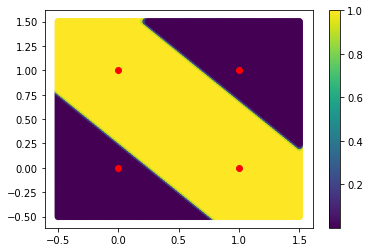

In [5]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.array([[10,10], [10,10]])
net.b1 = np.array([-5, -15])
net.W2 = np.array([[200, -200]])
net.b2 = np.array([-20])

# Hint: since we use the logistic sigmoid activation, the weights may need to 
# be fairly large 
 
sh = 100
xx, yy = np.meshgrid(np.linspace(-0.5,1.5,sh), np.linspace(-0.5,1.5,sh))
tmp_X = np.vstack([xx.ravel(), yy.ravel()]).T
c = net.forward(tmp_X, None, do_backward=False)[0]
plt.scatter(xx.ravel(), yy.ravel(), c=c.ravel())
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c='r')


net.forward(X, Y, do_backward=True)

# Problem 2 [2p]

1. Fill in the backward pass.
2. Implement random initialization of network parameters.
3. Using `float64` verify correctness of your backward pass.

In [6]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""
    
    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + '_grad')
    assert (param.shape == orig_grad.shape)

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (
            loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad, 

In [7]:
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ['W1', 'b1', 'W2', 'b2']:
    check_grad(net, param_name, X, Y)

# Problem 3 [2p]

Fill in the details of batch gradient descent below, then train a network to solve 2D XOR problem.

Then test the reliability of solving the 3D XOR task.

In [8]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 1e-1

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(i, loss)
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        param[:] = param - alpha * getattr(net, param_name + '_grad')

0 0.6989326322822225
5000 0.04292138366562172
10000 0.010799419550633836
15000 0.005719385680964691
20000 0.0037854460320127523
25000 0.0027905194506661415
30000 0.002191891769785515
35000 0.001795166589374975
40000 0.0015143896665150292
45000 0.00130598032216595
50000 0.0011455971681769471
55000 0.0010186256880781812
60000 0.0009157846748762542
65000 0.0008309091611276257
70000 0.0007597507109548575
75000 0.0006992904024732145
80000 0.000647326510053181
85000 0.0006022170732300875
90000 0.0005627136477754002
95000 0.0005278507597302423


In [9]:
net.forward(X, Y, do_backward=True)

(array([[2.36404015e-04],
        [9.99549009e-01],
        [9.99426980e-01],
        [7.26508908e-04]]), 0.0004968704985738599)

In [10]:
net.forward(X, Y, do_backward=True)

(array([[2.36404015e-04],
        [9.99549009e-01],
        [9.99426980e-01],
        [7.26508908e-04]]), 0.0004968704985738599)

Generate below data for a 3D XOR task. Try a few values of hidden layer size. Plot the reliability of training, i.e. how many trainings succeed for a given hiden layer size.

What is easier to train: a smaller, or large network?

In [12]:

X3 = np.array([[x, y, z] for x in [0,1] for y in [0,1] for z in [0,1]])
Y3 = (np.sum(X3, axis=-1) % 2).reshape(-1, 1)
res = defaultdict(list)
dims = [2, 3, 5, 10, 20]
for hidden_dim in tqdm(dims):
    for _try in tqdm(range(10)):
        net = SmallNet(3, hidden_dim, dtype=np.float64)
        alpha = 1e-1
        for i in range(100000):
            pred_Y, loss = net.forward(X3, Y3, do_backward=True)
            for param_name in ['W1', 'b1', 'W2', 'b2']:
                param = getattr(net, param_name)
                param[:] = param - alpha * getattr(net, param_name + '_grad')
        res[hidden_dim].append(np.sum((Y3 - pred_Y) * (Y3 - pred_Y)))





  0%|          | 0/5 [00:00<?, ?it/s]



  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [00:08<01:19,  8.80s/it]

 95%|█████████▍| 94882/100000 [00:26<00:00, 8563.90it/s]



 20%|██        | 2/10 [00:18<01:11,  8.96s/it]



 30%|███       | 3/10 [00:27<01:03,  9.06s/it]



 40%|████      | 4/10 [00:36<00:55,  9.18s/it]



 50%|█████     | 5/10 [00:46<00:46,  9.21s/it]



 60%|██████    | 6/10 [00:55<00:36,  9.22s/it]



 70%|███████   | 7/10 [01:04<00:27,  9.09s/it]



 80%|████████  | 8/10 [01:13<00:18,  9.17s/it]



 90%|█████████ | 9/10 [01:22<00:09,  9.03s/it]



100%|██████████| 10/10 [01:31<00:00,  9.20s/it]



 20%|██        | 1/5 [01:31<06:07, 91.97s/it]



  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [00:09<01:23,  9.28s/it]



 20%|██        | 2/10 [00:18<01:14,  9.35s/it]



 30%|███       | 3/10 [00:28<01:05,  9.40s/it]



 40%|████      | 4/10 [00:37<00:55,  9.23s/it]



 50%|█████     | 5/10 [00:46<00:46,  9.30s/it]



 60%|██████   

<BarContainer object of 5 artists>

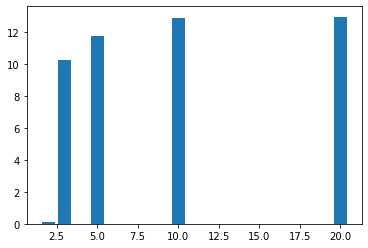

In [20]:
plt.bar(dims, -np.log([np.mean(res[x]) for x in dims]))

# Problem 4 [1bp]

Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Verify ho